In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch
warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 81

 ****************** Training and validation sets have been prepared **************** 

 prepare_single_data 
 prepare_semisingle_data 
 prepare_mix_data


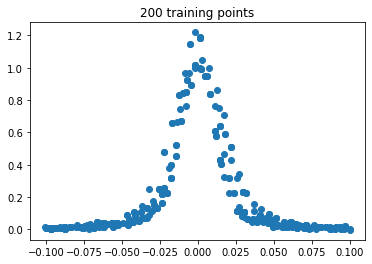

In [224]:
mode = 'Mixture'
%run EELS-ZLP.py

### Find uncertainties on data

44698


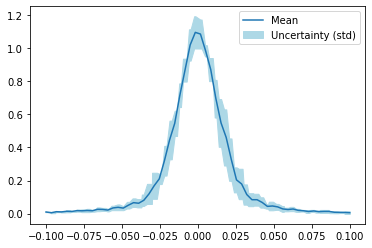

In [238]:
%run Functions.ipynb

nbins = 60

if mode == 'Mixture':
    x_train, y_train, x_val, y_val = prepare_mix_data()
if mode == 'Single':
    x_train, y_train = prepare_single_data()

# Create a plot of the mean & std 
plot_uncertainties(x_train, y_train, nbins)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train, variance_vector_t]

# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val, variance_vector_v]


## Neural Network 

### Create architecture

In [239]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(x, 5, activation=tf.nn.relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.relu)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    #hidden_layer_4 = tf.nn.dropout(hidden_layer_3, 0.01)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output

### Prepare data for training

In [240]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 1])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train)
N_test = len(df_val)

predictions = make_model(x, 1)

cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 8e-4
optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(cost)

train_x = np.array((df_train[:,0])).reshape(N_train,1)
train_y = np.array(df_train[:,1]).reshape(N_train,1)
train_sigma = np.array(df_train[:,2]).reshape(N_train,1)

test_x = np.array((df_val[:,0])).reshape(N_test,1)
test_y = np.array(df_val[:,1]).reshape(N_test,1)
test_sigma = np.array(df_val[:,2]).reshape(N_test,1)



### Train and validate

In [241]:
training_epochs = 10000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 500
prev_test_cost = np.inf
prev_epoch=0
avg_cost = 0.0

array_train = []
array_test = []
print("Start training on", '%04d' %(N_train), "samples")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        
        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x, 
                            y: train_y, 
                            sigma: train_sigma
                        })
        
        avg_cost = c 
        
        test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
        
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
            array_train.append(avg_cost)
            array_test.append(test_cost)
                         
        if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
            print(colored("\n The session stopped because of overfitting...","red"))
            print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
            break
            
        elif test_cost < prev_test_cost:
            prev_test_cost = test_cost
            prev_epoch = epoch
        
    
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: train_x, 
                            y: train_y
                        })

Start training on 44698 samples
Epoch: 0001 | Training cost= 35.158409119 | Validation cost= 33.430976868
Epoch: 0501 | Training cost= 19.201131821 | Validation cost= 19.043682098
Epoch: 1001 | Training cost= 6.007511616 | Validation cost= 5.970324993
Epoch: 1501 | Training cost= 1.879377127 | Validation cost= 1.918620348
Epoch: 2001 | Training cost= 1.319478750 | Validation cost= 1.339316964
Epoch: 2501 | Training cost= 1.226698875 | Validation cost= 1.243866205
Epoch: 3001 | Training cost= 1.184676766 | Validation cost= 1.198802948
Epoch: 3501 | Training cost= 1.170642734 | Validation cost= 1.184221387
Epoch: 4001 | Training cost= 1.165716887 | Validation cost= 1.179418921
Epoch: 4501 | Training cost= 1.163599849 | Validation cost= 1.178483248
Epoch: 5001 | Training cost= 1.163506866 | Validation cost= 1.178241968
Epoch: 5501 | Training cost= 1.166170001 | Validation cost= 1.178982258
Epoch: 6001 | Training cost= 1.161940098 | Validation cost= 1.176288962
Epoch: 6501 | Training cost=

### Plot outputs

44698


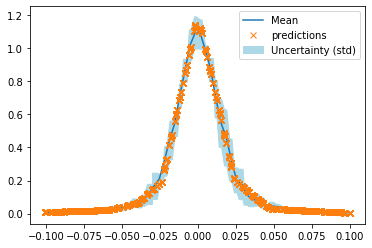

In [242]:
%run Functions.ipynb

plot_uncertainties(x_train, y_train, nbins)
plt.plot(train_x, predictions_values, 'x', label='predictions')
plt.legend()
plt.show()

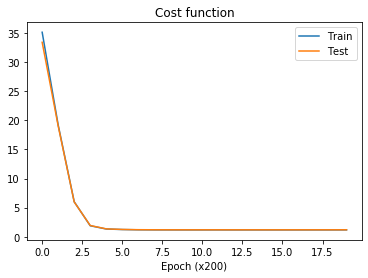

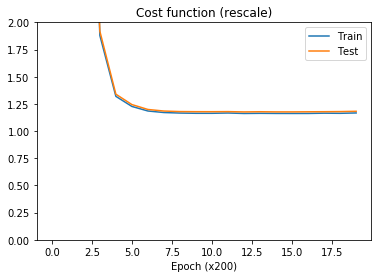

In [243]:
plt.plot(array_train, label='Train')
plt.plot(array_test, label='Test')
plt.title('Cost function')
plt.xlabel('Epoch (x200)')
plt.savefig('Figures/Cost function')
plt.legend()
plt.show()

plt.plot(array_train, label='Train')
plt.plot(array_test, label='Test')
plt.title('Cost function (rescale)')
plt.xlabel('Epoch (x200)')
plt.savefig('Figures/Cost function (rescale)')
plt.ylim([0,2])
plt.legend()
plt.show()

